In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

## Data Preprocessing

In [2]:
data = pd.read_csv('extended-leveraged-etfs.csv')
data.Date = pd.to_datetime(data.Date)
data.set_index(data.Date, inplace=True)
data = data.iloc[:,1:]

SCO = pd.read_csv('SCO 1991.csv')
SCO.Date = pd.to_datetime(SCO.Date)
SCO.set_index(SCO.Date, inplace=True)
SCO = SCO.iloc[:,1:]

data = pd.merge(left=data, right=SCO, left_index=True, right_index=True)

In [3]:
tickers = ['TQQQ', 'UPRO', 'TMF', 'SCO']
portfolio_weights = np.array([0.5,0.1,0.3,0.1])
assert round(sum(portfolio_weights),10)==1
assert len(tickers) == len(portfolio_weights)

## Backtesting functions

In [4]:
def makePortfolio(startDay = '2000-01-05', 
                  endDay = '2010-01-01',
                  tickers = ['TQQQ', 'UPRO', 'TMF', 'SCO'],
                  portfolio_weights = np.array([0.5,0.1,0.3,0.1]),
                  initial_investment = 1_000):

    backtestData = data.loc[startDay:endDay, tickers]

    n_shares = initial_investment * portfolio_weights/backtestData.iloc[0,:]
    portfolio = np.sum(n_shares*backtestData, axis=1)
    
    individualStocks = initial_investment*backtestData/backtestData.iloc[0,:]
    
    return portfolio, individualStocks


In [5]:
def _slice(startDay = '1999-06-01',
          endDay = '2000-12-31',
          nRebalance = 3):

    date_arr = list(data.loc[startDay:endDay,:].index)

    chunkSize = -int(-len(date_arr)/nRebalance)
#     print(chunkSize, len(date_arr))
    
    dateChunks = []
    
    for i in range(nRebalance+1):
        _d = date_arr[chunkSize*i:chunkSize*(i+1)]

        if len(_d)>2:

            dateChunks.append((_d[0],
                               _d[-1]))
    return dateChunks


In [6]:
def backtest_rebalance(startDay = '2000-01-05', 
                       endDay   = '2010-01-01',
                       tickers  = ['TQQQ', 'UPRO', 'TMF', 'SCO'],
                       portfolio_weights = np.array([0.5,0.1,0.3,0.1]),
                       initial_investment = 1_000,
                       nRebalance=3):
    
    date_arr = _slice(startDay = startDay ,endDay=endDay, nRebalance=nRebalance)
    rebalDate = [d[0] for d in date_arr]

    portfolio, _ = makePortfolio(startDay=date_arr[0][0],
                                                endDay=date_arr[0][1],
                                                portfolio_weights=portfolio_weights,
                                                initial_investment=initial_investment)

    for i in range(1, len(date_arr)):
        _p, _ = makePortfolio(startDay=date_arr[i][0],
                                endDay=date_arr[i][1],
                                portfolio_weights=portfolio_weights,
                                initial_investment=portfolio.iloc[-1])
        portfolio = portfolio.append(_p)
        
    backtestData = data.loc[startDay:endDay, tickers]
    individualStocks = initial_investment*backtestData/backtestData.iloc[0,:]

    return portfolio, individualStocks, rebalDate

In [25]:
def plot(portfolio, individualStocks, rebalDate=None, logScale=True):
    plt.figure(figsize=(16,9))
    plt.plot(portfolio, label='portfolio')

    for c in individualStocks.columns:
        plt.plot(individualStocks.loc[:,c], label=c)
        
    plt.legend()

    if rebalDate != None:
        plt.vlines(rebalDate, ymin=np.min(portfolio),
                   ymax=np.max(portfolio))
        
    if logScale:
        plt.yscale('log')

In [26]:
import itertools
x = np.linspace(0,1,11)
x = [round(i, 4) for i in x]
grids = [p for p in itertools.product(x, repeat=4) if sum(p)==1]
len(grids)

256

## Backtesting Results
### dot-com crisis

In [27]:
startDay = '1999-06-01'
endDay = '2001-12-31'
nRebalance = 3

sr_arr = []
mean_arr = []
std_arr = []

for w_arr in grids:
    w_arr = np.array(list(w_arr))
    portfolio, individualStocks, rebalDate  = backtest_rebalance(startDay=startDay,
                                                endDay=endDay,
                                                portfolio_weights=w_arr,
                                                                 nRebalance=nRebalance)
    
    portfolio_return = (portfolio.diff(1)/portfolio.shift(1))
    mean = np.mean(portfolio_return)
    std = np.std(portfolio_return)
    
    mean_arr.append(mean)
    std_arr.append(std)
    
    sr = mean/std
    sr_arr.append(sr)
    
#     print(w_arr, round(sr, 4))

sr_df = pd.concat([pd.DataFrame(grids),
                   pd.DataFrame(sr_arr), 
                   pd.DataFrame(mean_arr),
                   pd.DataFrame(std_arr)], axis=1)

sr_df.columns = ['w1','w2','w3','w4','sr', 'mean', 'std']
sr_df = sr_df.sort_values('sr', ascending=False)
sr_df.head()

,w1,w2,w3,w4,sr,mean,std
71,0.1,0.0,0.9,0.0,0.036617,0.000765,0.020885
120,0.2,0.0,0.8,0.0,0.034823,0.000928,0.026637
159,0.3,0.0,0.7,0.0,0.031480,0.000997,0.031672
10,0.0,0.0,1.0,0.0,0.031268,0.000528,0.016893
70,0.1,0.0,0.8,0.1,0.029729,0.000620,0.020854


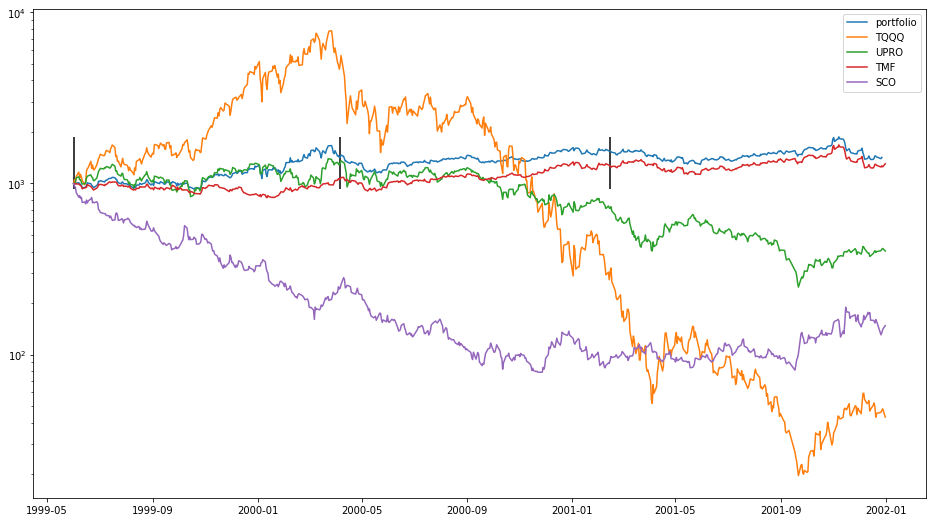

In [28]:
w_arr = np.array(sr_df.iloc[0,:4])

portfolio, individualStocks, rebalDate  = backtest_rebalance(startDay=startDay,
                                            endDay=endDay,
                                            portfolio_weights=w_arr, nRebalance=nRebalance)
    

plot(portfolio, individualStocks, rebalDate)

### Subprime

    w1   w2   w3   w4        sr      mean       std
5  0.0  0.0  0.5  0.5  0.016107  0.000563  0.034953
4  0.0  0.0  0.4  0.6  0.016091  0.000603  0.037495
6  0.0  0.0  0.6  0.4  0.015561  0.000505  0.032422
3  0.0  0.0  0.3  0.7  0.015470  0.000620  0.040064
7  0.0  0.0  0.7  0.3  0.014474  0.000434  0.029964


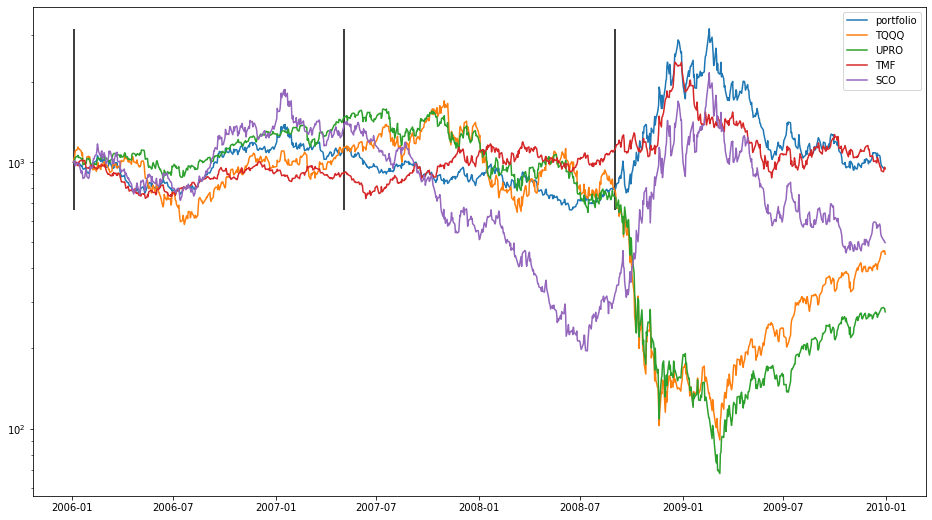

In [29]:
startDay = '2006-01-01'
endDay = '2009-12-31'
nRebalance = 3

sr_arr = []
mean_arr = []
std_arr = []

for w_arr in grids:
    w_arr = np.array(list(w_arr))
    portfolio, individualStocks, rebalDate  = backtest_rebalance(startDay=startDay,
                                                endDay=endDay,
                                                portfolio_weights=w_arr,
                                                                 nRebalance=nRebalance)
    
    portfolio_return = (portfolio.diff(1)/portfolio.shift(1))
    mean = np.mean(portfolio_return)
    std = np.std(portfolio_return)
    
    mean_arr.append(mean)
    std_arr.append(std)
    
    sr = mean/std
    sr_arr.append(sr)
    
#     print(w_arr, round(sr, 4))

sr_df = pd.concat([pd.DataFrame(grids),
                   pd.DataFrame(sr_arr), 
                   pd.DataFrame(mean_arr),
                   pd.DataFrame(std_arr)], axis=1)

sr_df.columns = ['w1','w2','w3','w4','sr', 'mean', 'std']
sr_df = sr_df.sort_values('sr', ascending=False)
print(sr_df.head())

w_arr = np.array(sr_df.iloc[0,:4])

portfolio, individualStocks, rebalDate  = backtest_rebalance(startDay=startDay,
                                            endDay=endDay,
                                            portfolio_weights=w_arr, nRebalance=nRebalance)

plot(portfolio, individualStocks, rebalDate)

### Other periods

In [30]:
startDay = '2010-01-05'
endDay = '2019-12-31'

nRebalance = 20

sr_arr = []
mean_arr = []
std_arr = []

for w_arr in grids:
    w_arr = np.array(list(w_arr))
    portfolio, individualStocks, rebalDate  = backtest_rebalance(startDay=startDay,
                                                endDay=endDay,
                                                portfolio_weights=w_arr,
                                                                 nRebalance=nRebalance)
    
    portfolio_return = (portfolio.diff(1)/portfolio.shift(1))
    mean = np.mean(portfolio_return)
    std = np.std(portfolio_return)
    
    mean_arr.append(mean)
    std_arr.append(std)
    
    sr = mean/std
    sr_arr.append(sr)
    
#     print(w_arr, round(sr, 4))

sr_df = pd.concat([pd.DataFrame(grids),
                   pd.DataFrame(sr_arr), 
                   pd.DataFrame(mean_arr),
                   pd.DataFrame(std_arr)], axis=1)

sr_df.columns = ['w1','w2','w3','w4','sr', 'mean', 'std']
sr_df = sr_df.sort_values('sr', ascending=False)
sr_df.head()

,w1,w2,w3,w4,sr,mean,std
171,0.3,0.2,0.4,0.1,0.084343,0.001167,0.013842
195,0.4,0.1,0.4,0.1,0.084214,0.001218,0.014464
140,0.2,0.3,0.4,0.1,0.083939,0.001117,0.013305
214,0.5,0.0,0.4,0.1,0.083693,0.001269,0.015158
99,0.1,0.4,0.4,0.1,0.082853,0.001066,0.012867


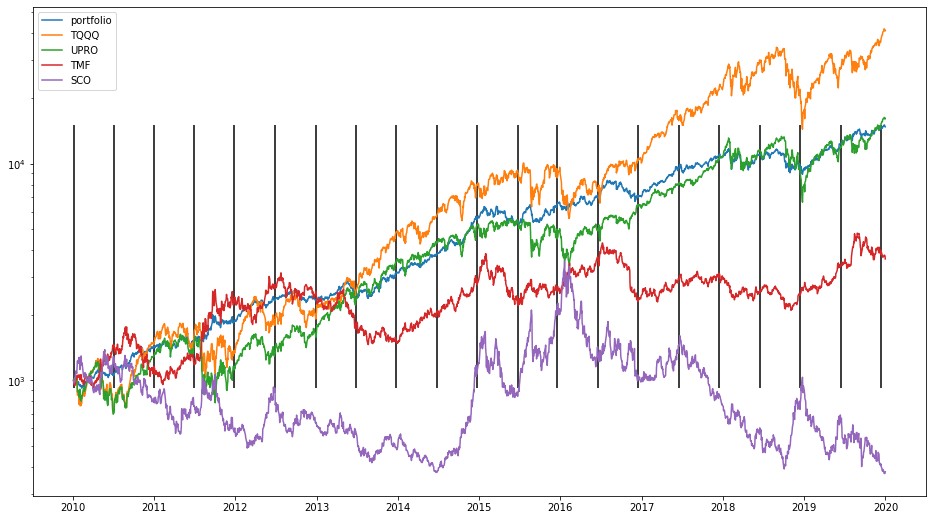

In [31]:
w_arr = np.array(sr_df.iloc[0,:4])

portfolio, individualStocks, rebalDate  = backtest_rebalance(startDay=startDay,
                                            endDay=endDay,
                                            portfolio_weights=w_arr, nRebalance=nRebalance)
    

plot(portfolio, individualStocks, rebalDate)

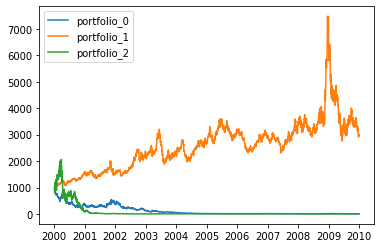

In [242]:
i_arr = [0,1,2]

for i in i_arr:
    w_arr = np.array(sr_df.iloc[i,:4])

    portfolio, individualStocks = makePortfolio(portfolio_weights=w_arr)
    portfolio_return = (portfolio.diff(1)/portfolio.shift(1))

    plt.plot(portfolio,label='portfolio_%i'%i)
    
plt.legend()